# Image classifiers

In [1]:
# Imports to be used through the notebook

import torch 
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import time

import utils

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Data (MNIST)

In [3]:
# We define a transformation to apply to the items of the dataset (that are, by default, in PIL image format). The standardization will help with training.

MEAN_MNIST = (0.1307,)
STD_MNIST = (0.3081,)

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN_MNIST, STD_MNIST)])

transform_mnist_unnormalized = transforms.Compose([
    transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=True,
                                        download=True, transform=transform_mnist_unnormalized)

testset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=False,
                                       download=True, transform=transform_mnist_unnormalized)


#trainset.__len__() # yields 60000
#trainset.__getitem__(0) # tuple (image, class); image is a tensor 1x28x28 and class is an int
#trainset.__getitem__(0)[0].shape #yields torch.Size([1, 28, 28])

In [4]:
# Trainloaders are dataset wrappers used to access them in a batched way. Of course this is very useful for NN training.
batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("Size train loader: ", len(trainloader), " | test loader: ", len(testloader))

Size train loader:  1875  | test loader:  313


In [5]:
batch = next(iter(trainloader)) # batches are lists of two tensors, one containing features and other labels.

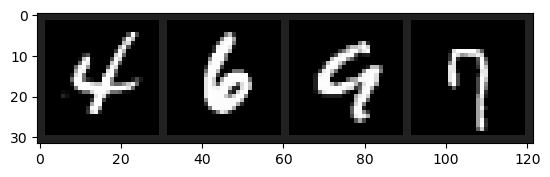

Labels:      4             6             9             7 

Image shape (number of channels, height, width): (1, 28, 28)


In [6]:
# functions to show an image
def imshow(img):
    img = img * STD_MNIST[0] + MEAN_MNIST[0]  # Proper unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # MNIST is grayscale + original tensor shape is (1,28,28) so  np.transpose(img, (1, 2, 0)) gets it to shape (28,28,1) 
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:     ','             '.join(f'{labels[j]}' for j in range(4)), '\n')
print(f'Image shape (number of channels, height, width): {tuple(images[0].shape)}')

## First model
Note that this model outputs logits; not probabilities!

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(1690, output_channels)

    def forward(self, x):
        # Initial shape is [B, 1, 28, 28]
        x = self.conv(x)
        # After convoluting, shape is [B, 10, 26, 26]
        x = nn.ReLU()(x)
        # After ReLU, shape is [B, 10, 26, 26] (it's an element-wise operation)
        x = self.pool(x)
        # After pooling, shape is [B, 10, 13, 13]
        x = nn.Flatten()(x)
        # After flattening shape is [B, 1690] (naturally, 1690 = 10x13x13)
        x = self.fc(x)
        # Final shape is [B, 10] (we have logits for 10 possible classes)
        return x

In [8]:
len(batch[0])

32

### Training 

In [6]:
input_channels=1
output_shape=10
criterion = nn.CrossEntropyLoss()


def build_and_train_model(archi=SimpleCNN, trainloader=trainloader, input_shape=input_channels, output_shape=output_shape, optimizer=optim.SGD, criterion=criterion, device="cpu", n_epochs=20, lr=0.01):
 
  # When building a model, you assign it to a particular device by setting: model = model.to(device); device is indicated by a string, like "cpu" our "cuda:0"
  model = archi(input_shape,output_shape).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (x,y) in enumerate(trainloader):
      # Same as for the model, you have to assign a device for your inputs and your label, for example: x = x.to(device)
      inputs, labels = x.to(device), y.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    print(f'Epoch {epoch} / {n_epochs} | Loss: {running_loss / len(trainloader)}')
    running_loss = 0.0
  return model

In [7]:
start_time = time.time()
model = build_and_train_model(device=device)
print(f"Training with {device} lasts: {np.round((time.time()-start_time)/60,2)} minutes\n")

Epoch 0 / 20 | Loss: 0.2808903154010574
Epoch 1 / 20 | Loss: 0.10869014572103819
Epoch 2 / 20 | Loss: 0.07820359647180886
Epoch 3 / 20 | Loss: 0.06514626938644796
Epoch 4 / 20 | Loss: 0.05589691630685702
Epoch 5 / 20 | Loss: 0.05097346098938336
Epoch 6 / 20 | Loss: 0.04723241805881262
Epoch 7 / 20 | Loss: 0.0428250704837963
Epoch 8 / 20 | Loss: 0.039861478072001286
Epoch 9 / 20 | Loss: 0.03756430459135833
Epoch 10 / 20 | Loss: 0.03545104061832341
Epoch 11 / 20 | Loss: 0.03348648899283726
Epoch 12 / 20 | Loss: 0.030768845820279483
Epoch 13 / 20 | Loss: 0.02967828694120981
Epoch 14 / 20 | Loss: 0.0276612089800726
Epoch 15 / 20 | Loss: 0.026203384472705267
Epoch 16 / 20 | Loss: 0.02476732923233455
Epoch 17 / 20 | Loss: 0.023499608637047156
Epoch 18 / 20 | Loss: 0.022434070594934748
Epoch 19 / 20 | Loss: 0.021652104863669957
Training with cuda:0 lasts: 2.56 minutes



In [8]:
# Once your model has been trained, you have to evaluate it on the test set.
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for X, y in dataloader:
          pred = model(X.to(device))
          loss = loss_fn(pred, y.to(device)).item()
          test_loss += loss
          # Your current output is the for each class to be the right one.
          prediction = pred.argmax(axis=1)
          # To compute the accuracy score, we need to know how many correct predictions we got.
          correct += (prediction == y.to(device)).sum().item()
          ###
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [9]:
loss = test_loop(testloader, model, criterion, device)

Test Error: Accuracy: 98.4%, Avg loss: 0.060009 



In [10]:
torch.save(model.state_dict(), 'Models/MNISTsmall-unnormalized.pt')

## Second model with final softmax

In [ ]:
class SimpleCNNprobas(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(1690, output_channels)

    def forward(self, x):
        # Initial shape is [B, 1, 28, 28]
        x = self.conv(x)
        # After convoluting, shape is [B, 10, 26, 26]
        x = nn.ReLU()(x)
        # After ReLU, shape is [B, 10, 26, 26] (it's an element-wise operation)
        x = self.pool(x)
        # After pooling, shape is [B, 10, 13, 13]
        x = nn.Flatten()(x)
        # After flattening shape is [B, 1690] (naturally, 1690 = 10x13x13)
        x = self.fc(x)
        # Final shape is [B, 10] (we have logits for 10 possible classes)
        x = nn.functional.softmax(x, dim=1)   
        # Does not change shape either
        return x